## Ładujemy biblioteki i dane

In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold, KFold, learning_curve
from sklearn.metrics import mean_squared_error as mse, precision_score, recall_score
from sklearn import utils

from scikitplot.metrics import plot_confusion_matrix, plot_calibration_curve
# from scikitplot.estimators import plot_learning_curve, plot_feature_importances

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import xgboost as xgb
from collections import defaultdict 

import gc
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

%matplotlib inline

/home/jan/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/jan/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
train = pd.read_hdf('data/train_online_retail.h5').reset_index(drop=True)

In [5]:
train.head()

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test
0,2,12,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.949219,59.500000,1,United Kingdom,False,False
1,2,13,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.449219,98.099998,1,United Kingdom,False,False
2,2,14,HOME BUILDING BLOCK WORD,3,2009-12-01 09:06:00,5.949219,17.850000,1,United Kingdom,False,False
3,2,15,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.690430,27.040001,1,United Kingdom,False,False
4,2,16,PEACE WOODEN BLOCK LETTERS,3,2009-12-01 09:06:00,6.949219,20.850000,1,United Kingdom,False,False


## Do danych dodajemy cechy opisujące jak często przedmiot o danym stock code był zwracany (liczba absolutna zwrotów i udział zwrotów)

In [6]:
from collections import defaultdict

stock_code_num = dict(train['stock_code'].value_counts())
stock_code_canc =  dict(train[train['is_canceled'] == True]['stock_code'].value_counts())

stock_code_rat = {}

for key in stock_code_num:
    if key not in stock_code_canc:
        stock_code_canc[key] = 0
        stock_code_rat[key] = 0
    else:
        stock_code_rat[key] = stock_code_canc[key]/stock_code_num[key]
        
mean_canc = np.mean(list(stock_code_canc.values()))
mean_rat = np.mean(list(stock_code_rat.values()))

stock_code_canc = defaultdict(lambda: mean_canc, stock_code_canc)
stock_code_rat = defaultdict(lambda: mean_rat, stock_code_rat)


In [7]:
train['stock_code_rat'] = train['stock_code'].map(stock_code_rat)
train['stock_code_canc'] = train['stock_code'].map(stock_code_canc)

## Stworzenie docelowego źródła danych - tabela zamówień

Przy okazji tworzenia tabeli zamówień generujemy nowe cechy, takie jak mediana ceny, cena najdroższego itemu, największa ilość sztuk danego itemu, a także cechy zależne od parametrów mówiących jak często były zwracane dane produkty. Dodałem też cechy opisujące datę zamówienia (a także dzień tygodnia zamówienia)

In [9]:
orders = train.groupby('invoice').agg(
    num_canceled=('is_canceled', sum), item_num=('price_total', 'count'),
    price_total=('price_total', sum), m_expensive_item_total=('price_total', max),
    item_median_total=('price_total', np.median), l_expensive_item_total=('price_total', min),
    sum_quant=('quantity', sum), great_quant=('quantity', max), least_quent=('quantity', min),
    date=('invoice_date', 'first'), country=('country', 'first'),
    customer_id=('customer_id', 'first'),
    mean_scrat=('stock_code_rat', np.mean), min_scrat=('stock_code_rat', min),
    max_scrat=('stock_code_rat', max),
    mean_sccanc=('stock_code_canc', np.mean), min_sccanc=('stock_code_canc', min),
    max_sccanc=('stock_code_canc', max))

orders["date"] = orders['date'].astype("datetime64")
orders['year'] = orders['date'].dt.year
orders['month'] = orders['date'].dt.month
orders['weekday'] = orders['date'].dt.weekday
orders['hour'] = orders['date'].dt.hour


orders['is_canceled'] = orders['num_canceled'] > 0
orders['total_return'] = orders['price_total'] * orders['is_canceled']

orders['country_val'] = pd.factorize(orders['country'])[0]

In [10]:
orders.dtypes

num_canceled                     float64
item_num                           int64
price_total                      float32
m_expensive_item_total           float32
item_median_total                float32
l_expensive_item_total           float32
sum_quant                          int32
great_quant                        int32
least_quent                        int32
date                      datetime64[ns]
country                           object
customer_id                        int16
mean_scrat                       float64
min_scrat                        float64
max_scrat                        float64
mean_sccanc                      float64
min_sccanc                         int64
max_sccanc                         int64
year                               int64
month                              int64
weekday                            int64
hour                               int64
is_canceled                         bool
total_return                     float32
country_val     

Chciałem przyjrzeć się temu, jak wygląda kwestia różnych klientów. Wśród klientów wyróżniłem tych stałych, tj. takich którzy mają co najmniej 20 zamówień. Miało to służyć przede wszystkim temu, żebym mógł potem przypisać zamówieniom częstość zwrotów przez danego zamawiąjącego. Ale nie chciałem tego robić dla klientów, którzy mają tylko kilka zamówień. Dlaczego? Dlatego, że jeśli dany klient miał kilka zamówień i żadnego zwrotu, to cecha "częstość zwrotów przez klienta" będzie wynosiła 0%. Ale wtedy możemy uzyskać model, który nauczy się, że jeśli częstość zwrotów przez klienta = 0%, to dane zamówienie też na pewno nie mogło być zwrócone, bo wtedy częstość zwrotów byłaby niezerowa. A to błąd, bo to że nie mamy zwrotów danego klienta w zbiorze treningowym nie oznacza, że w zbiorze testowym ten klient nie zwróci zamówienia.

In [13]:
customers = orders.groupby('customer_id').agg(invoices=('price_total', 'count'), returns=('is_canceled', sum))
regulars = customers[customers['invoices'] > 19].index

### Oddzieliłem zamówienia o łącznej wartości powyżej 25000.

A to dlatego, że dopóki są obecne nie byłbym w stanie w ogóle wyciągnąć żadnych sensownych informacji o tym, jakie mse uzyskuje. Niestety mse jest tutaj dość niefortunną metryką. Z tego co sprawdzałem, to jakieś 80% udziału w mse ma tylko 10 największych zamówień. A to oznacza, że dopóki te największe zamówienia są w zbiorze treningowym, uzyskane mse będzie praktycznie wyłącznie mówić nam o tym, jak dobrze model jest dopasowany do tych kilku największych zamówień, a zatem będziemy mieć problem z overfittingiem.

Usunięcie zamówień o wartości powyżej 25000 pozwala trochę wygładzić ten problem.

Zamówienia podzieliłem też na zamówienia stałych klientów i pozostałych.

In [14]:
orders_top = orders[orders['price_total'] >= 25000]
orders_r = orders[orders['price_total'] < 25000]
orders_rr = orders_r[orders_r['customer_id'].isin(regulars)]
orders_rn = orders_r[~orders_r['customer_id'].isin(regulars)]

### Dla stałych klientów do cech zamówienia dodałem liczbę zamówień klienta, liczbę zwrotów i stosunek zwrotów

In [15]:
orders_rr['cust_inv'] = orders_rr['customer_id'].map(lambda x: customers.loc[x]['invoices'])
orders_rr['cust_canc'] = orders_rr['customer_id'].map(lambda x: customers.loc[x]['returns'])
orders_rr['cust_rat'] = orders_rr['cust_canc']/orders_rr['cust_inv']

/home/jan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

### Tu niestety trochę rzeźbienia wynikającego z tego, że cechy przekazujemy jako macierz numpy (bez nazw kolumn), a potrzebuję wiedzieć, która kolumna to 'price_total'

In [16]:
def get_n_total_price(df):
    feats = df.select_dtypes(include=[np.int32, np.int64, np.float32, np.float64]).columns

    X_feats = feats[ (feats != 'num_canceled') & (feats != 'is_canceled') & (feats != 'total_return')].values
    return np.where(X_feats == 'price_total')[0][0]

def get_X_and_y(df):

    feats = df.select_dtypes(include=[np.int32, np.int64, np.float32, np.float64]).columns

    X_feats = feats[ (feats != 'num_canceled') & (feats != 'is_canceled') & (feats != 'total_return')].values
    X = df[X_feats].values
    y = df['total_return'].values
    
    return X, y

### 3 różne podejścia do obliczenia wysokości zwrotu

Funkcje mają parametr *mode*, który określa z jakim modelem funkcja będzie miała do czynienia i jak liczony będzie zwrot. 'regr' oznacza, że model jest regresorem, 'class': że model jest klasyfikatorem i albo przewidujemy zwrot w wysokości całej wartości zamówienia, albo żaden, zaś 'class_prob': że model jest klasyfikatorem, ale przewidywany zwrot to prawdopodobieństwo, że nastąpi zwrot mnożone przez wartość zamówienia.

Ponieważ miarę zwycięstwa jest mse, ten ostatni powienien mieć przewagę, zwłaszcza tam, gdy mamy mało pewności, czy w danym przypadku dojdzie do zwrotu czy nie. Np. dla przewidywanego prawdopobieństwa zwrotu = 1/2, jeśli wartość zamówienia to D, wówczas wartość oczekiwana mse przy użyciu klasyfikatora zwykłego wynosi 1/2*D^2*, zaś przy użyciu 'class_prob' wartość oczekiwana to 1/4*D^2*

In [18]:
def plot_learning_curve(model, X, y, mode, n_total_price=0, for_class=False):
    # mode: 'regr', 'class' or 'class_prob'
    
    def class_scorer(model, X, y):
        y_pred_class = model.predict(X)
        
        
        y_pred = y_pred_class*X[:,n_total_price].reshape(X.shape[0])
        y_true = y*X[:,n_total_price].reshape(X.shape[0])
        
        return mse(y_true, y_pred)
    
    def class_prob_scorer(model, X, y):
        y_pred_prob = model.predict_proba(X)
        
        y_pred = y_pred_prob[:,1]*X[:,n_total_price].reshape(X.shape[0])
        y_true = y*X[:,n_total_price].reshape(X.shape[0])
        
        return mse(y_true, y_pred)
    
    
    if for_class:
        y_class = list(map(lambda x: x > 0, y))
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y_class, scoring='accuracy')
    else:
        if mode == 'regr':
            train_sizes, train_scores, test_scores = learning_curve(
                model, X, y, scoring='neg_mean_squared_error')
        elif mode == 'class':
            y_class = list(map(lambda x: x > 0, y))
            train_sizes, train_scores, test_scores = learning_curve(
                model, X, y_class, scoring=class_scorer)
        elif mode == 'class_prob':
            y_class = list(map(lambda x: x > 0, y))
            train_sizes, train_scores, test_scores = learning_curve(
                model, X, y_class, scoring=class_prob_scorer)
            
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

def test_model(model, X, y, mode, weights=None, n_total_price=0, plot=True):
    
    # mode: 'class', 'regr' or 'class_prob'
    
    

    group_kfold = KFold(n_splits=4)
    groups = [0,0,1,2]

    scores = []
    for train_index, test_index in group_kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if weights != None:
            weights = weights[train_index]
        
        if mode == 'regr':
            model.fit(X_train, y_train)
        else:
            y_train_class = list(map(lambda x: x > 0, y_train))
            model.fit(X_train, y_train_class, weights)
        
        if mode == 'regr':
            y_pred = model.predict(X_test)
        elif mode == 'class':
            y_pred = model.predict(X_test)*X_test[:,n_total_price].reshape(X_test.shape[0])
        elif mode == 'class_prob':
            y_pred = model.predict_proba(X_test)[:,1]*X_test[:,n_total_price].reshape(X_test.shape[0])
            
        scores.append(mse(y_test, y_pred))
        
    print(type(model).__name__)
    print('Mean score: ', np.mean(scores))
    print('Std: ', np.std(scores))
    
    if plot:
        if mode == 'regr':
            plt = plot_learning_curve(model, X, y, mode='regr')
            plt.show()
        else:
            plt = plot_learning_curve(model, X, y, mode=mode, n_total_price=n_total_price)
            plt.show()
            plt = plot_learning_curve(model, X, y, mode=mode, for_class=True, n_total_price=n_total_price)
            plt.show()
        
    return model

### Trenuje oddzielne modele dla zbioru zamówień stałych klientów i pozostałych

Pamiętająmy, że uzyskiwane tu wyniki mse są mniejsze, ponieważ usunęliśmy zamówienia o wartości powyżej 25000, które najbardziej podnosiły mse

Zaczynam od regresorów

DummyRegressor
Mean score:  189236.33
Std:  178765.75


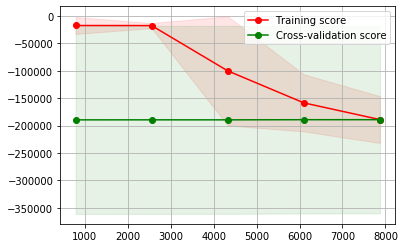

In [62]:
model = DummyRegressor()

X, y = get_X_and_y(orders_rr)

test_model(model, X, y, mode='regr')

DecisionTreeRegressor
Mean score:  126706.09813074859
Std:  83332.15226695144


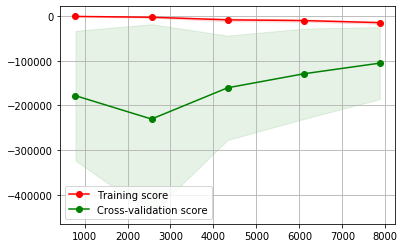

In [71]:
model = DecisionTreeRegressor(max_depth=5)

X, y = get_X_and_y(orders_rr)

test_model(model, X, y, mode='regr')

RandomForestRegressor
Mean score:  104870.5958463324
Std:  56451.36122813544


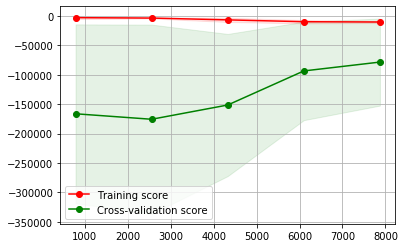

In [72]:
model = RandomForestRegressor()

X, y = get_X_and_y(orders_rr)

test_model(model, X, y, mode='regr')

RandomForestRegressor
Mean score:  93755.8145309892
Std:  41383.714846566705


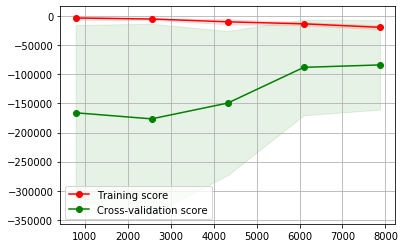

In [74]:
model = RandomForestRegressor(max_depth=5, n_estimators=100, max_features=10)

X, y = get_X_and_y(orders_rr)

test_model(model, X, y, mode='regr')

XGBRegressor
Mean score:  125442.625
Std:  92407.664


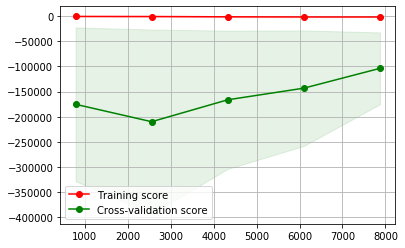

In [76]:
model = xgb.XGBRegressor(nrounds = 1000, max_depth=10)

X, y = get_X_and_y(orders_rr)

test_model(model, X, y, mode='regr')

## Jak widać najlepszy wynik uzyskano dla RandomForrest, wszystkie modele mają problem z overfittingiem, ale XGB wyjątkowo

### Teraz trenowanie klasyfikatorów z liczenie zwrotu zgodnie z parametrem 'class'

Wykresy krzywej uczenia przedstawiają mse i trafność

DecisionTreeClassifier
Mean score:  65443.18857904374
Std:  52703.264974780424


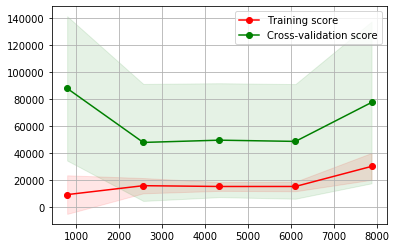

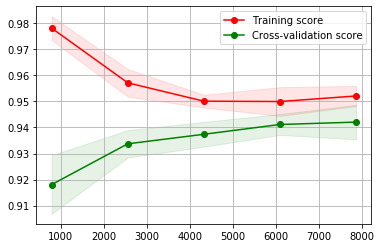

In [117]:
model = DecisionTreeClassifier(max_depth=5)

X, y = get_X_and_y(orders_rr)
ntp = get_n_total_price(orders_rr)

test_model(model, X, y, mode='class', n_total_price=ntp)

RandomForestClassifier
Mean score:  72736.62923710473
Std:  48417.510245016965


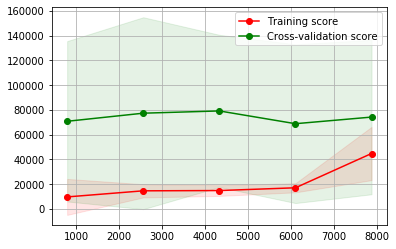

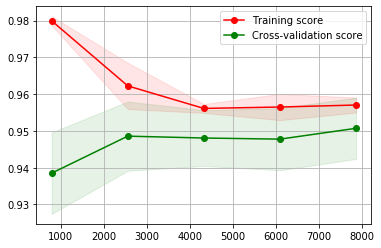

In [118]:
model = RandomForestClassifier(max_depth=5)

X, y = get_X_and_y(orders_rr)
ntp = get_n_total_price(orders_rr)

test_model(model, X, y, mode='class', n_total_price=ntp)

## Dla RandomForrest uzyskaliśmy najlepsze mse, ok. 72000. Zobaczmy co będzie, jeśli liczenie przewidywanego zwrotu będziemy robić na sposób 'class_prob'

RandomForestClassifier
Mean score:  52297.308350641644
Std:  31901.215161242653


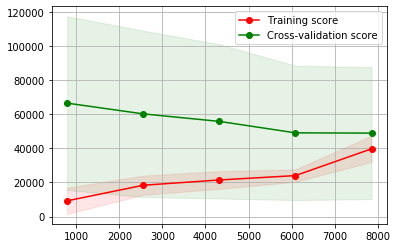

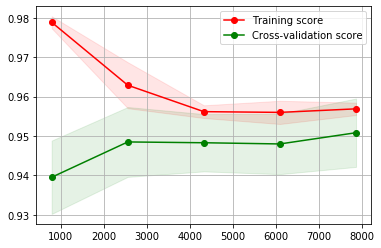

In [128]:
model = RandomForestClassifier(max_depth=5)

X, y = get_X_and_y(orders_rr)
ntp = get_n_total_price(orders_rr)

test_model(model, X, y, mode='class_prob', n_total_price=ntp)

## Jak widać udało nam się zmniejszyć mse do ok. 52000

Następnie ćwiczymy modele dla zbioru zamówień klientów niestałych

RandomForestClassifier
Mean score:  24344.679858069205
Std:  17658.105860748827


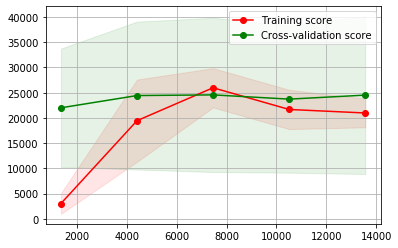

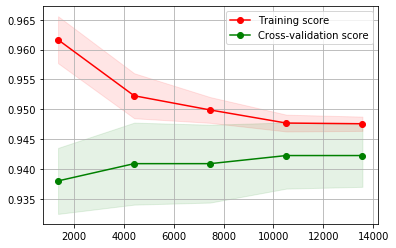

In [127]:
model = RandomForestClassifier(max_depth=5)

X, y = get_X_and_y(orders_rn)
ntp = get_n_total_price(orders_rn)

test_model(model, X, y, mode='class_prob', n_total_price=ntp)

/home/jan/.local/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/jan/.local/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/jan/.local/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/jan/.local/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/jan/.local/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified 

DummyClassifier
Mean score:  108330.02138436705
Std:  51740.30535388723


/home/jan/.local/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/jan/.local/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


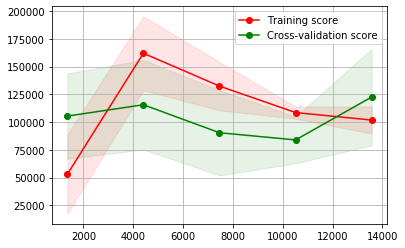

/home/jan/.local/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


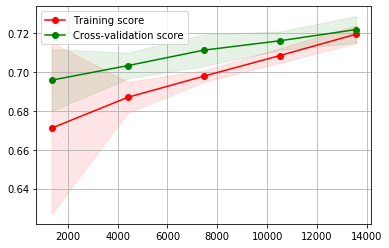

In [129]:
model = DummyClassifier()

X, y = get_X_and_y(orders_rn)
ntp = get_n_total_price(orders_rn)

test_model(model, X, y, mode='class_prob', n_total_price=ntp)

## Spróbujmy jest użyć XGB, tym razem z parametrem 'class_prob'

Niestety mamy duży overfitting bez poprawy wyniku walidowaneg, dlatego wolałem pozostać przy lasach losowych

XGBClassifier
Mean score:  52216.972069008974
Std:  33168.029888446006


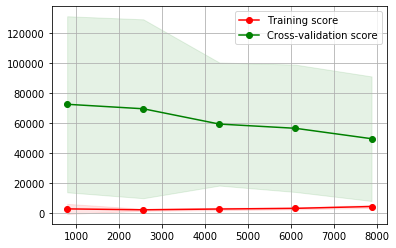

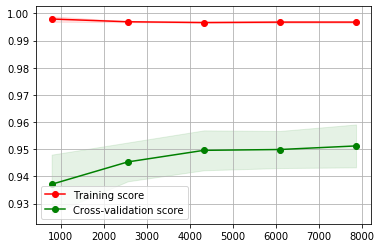

In [135]:
model = xgb.XGBClassifier()

X, y = get_X_and_y(orders_rr)
ntp = get_n_total_price(orders_rr)

test_model(model, X, y, mode='class_prob', n_total_price=ntp)

XGBClassifier
Mean score:  25784.551068224275
Std:  20109.038508268804


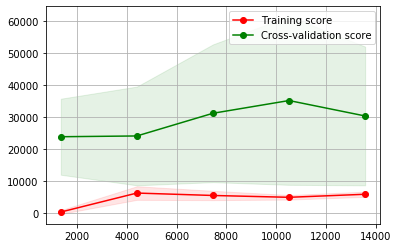

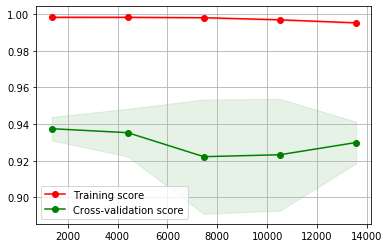

In [134]:
model = xgb.XGBClassifier()

X, y = get_X_and_y(orders_rn)
ntp = get_n_total_price(orders_rn)

test_model(model, X, y, mode='class_prob', n_total_price=ntp)

9839 (9839, 22)
RandomForestClassifier
Mean score:  50198.496483367024
Std:  27793.60056924764


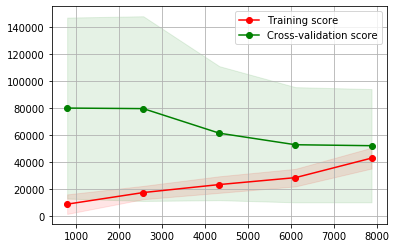

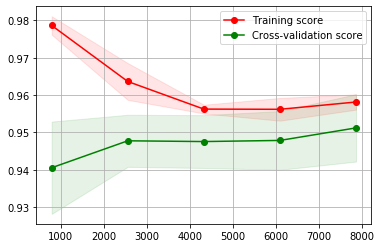

In [141]:
model = RandomForestClassifier(max_depth=5)

X, y = get_X_and_y(orders_rr)
ntp = get_n_total_price(orders_rr)

print(len(orders_rr), X.shape)

test_model(model, X, y, mode='class_prob', n_total_price=ntp, weights=orders_rr['price_total'].values)

XGBClassifier
Mean score:  70254.70715179408
Std:  47492.05968332055


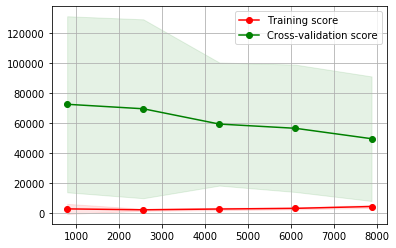

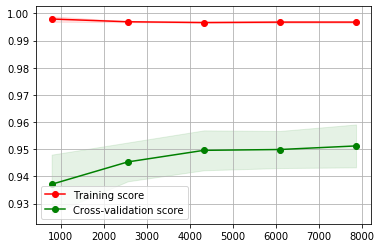

In [142]:
model = xgb.XGBClassifier()

X, y = get_X_and_y(orders_rr)
ntp = get_n_total_price(orders_rr)

test_model(model, X, y, mode='class_prob', n_total_price=ntp, weights=orders_rr['price_total'].values)

9839 (16962, 19)
RandomForestClassifier
Mean score:  25853.002147139083
Std:  16839.735672062114


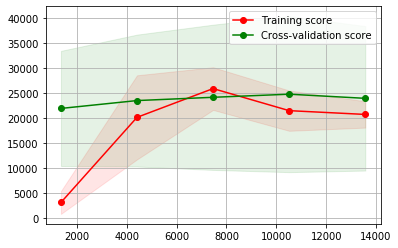

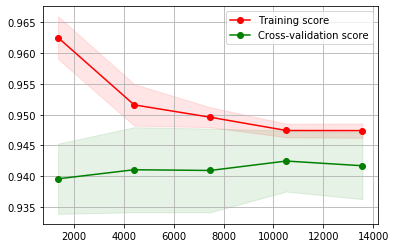

In [143]:
model = RandomForestClassifier(max_depth=5)

X, y = get_X_and_y(orders_rn)
ntp = get_n_total_price(orders_rn)

print(len(orders_rr), X.shape)

test_model(model, X, y, mode='class_prob', n_total_price=ntp, weights=orders_rn['price_total'].values)

## Tu chciałem jeszcze sprawdzić, czy nasze mse wciąż zależy głównie od pojedynczych zamówień. Niestety wciąż tak jest, trochę inny wybór zbioru testowego zmienia mse z 3900 na 26500

RandomForestClassifier
Mean score:  3932.3664803827596
Std:  3180.4338754088535


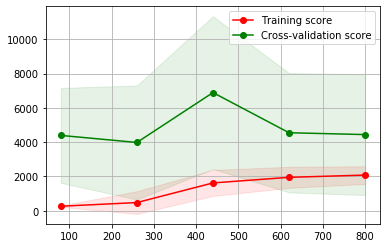

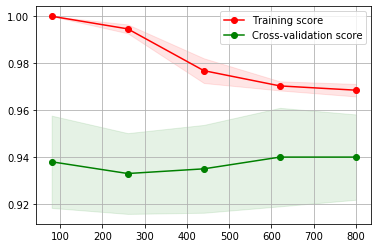

26564.345923187317


In [156]:
tr_rn, te_rn = orders_rn.iloc[:1000], orders_rn.iloc[1000:]

model = RandomForestClassifier(max_depth=5)

X_tr, y_tr = get_X_and_y(tr_rn)
X_te, y_te = get_X_and_y(te_rn)
ntp = get_n_total_price(orders_rn)


tr_model = test_model(model, X_tr, y_tr, mode='class_prob', n_total_price=ntp)



y_pred_prob = tr_model.predict_proba(X_te)
y_pred = y_pred_prob[:,1]*X_te[:,ntp].reshape(X_te.shape[0])

print(mse(y_te, y_pred))

RandomForestClassifier
Mean score:  31257.535449045386
Std:  27946.75988487577


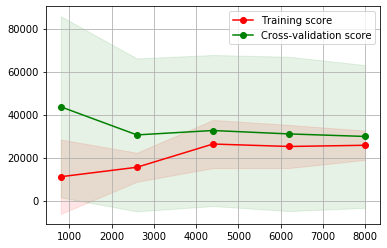

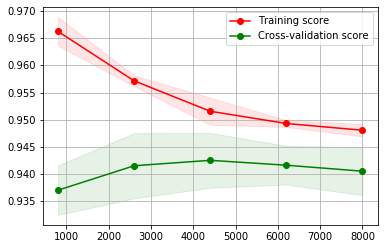

11586.190830610745


In [157]:
tr_rn, te_rn = orders_rn.iloc[:10000], orders_rn.iloc[10000:]

model = RandomForestClassifier(max_depth=5)

X_tr, y_tr = get_X_and_y(tr_rn)
X_te, y_te = get_X_and_y(te_rn)
ntp = get_n_total_price(orders_rn)


tr_model = test_model(model, X_tr, y_tr, mode='class_prob', n_total_price=ntp)



y_pred_prob = tr_model.predict_proba(X_te)
y_pred = y_pred_prob[:,1]*X_te[:,ntp].reshape(X_te.shape[0])

print(mse(y_te, y_pred))

RandomForestClassifier
Mean score:  9572.533834373695
Std:  5642.9247528951


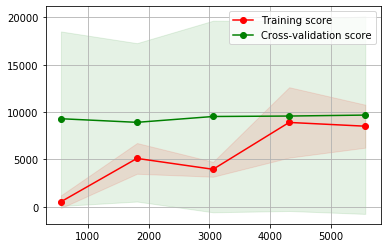

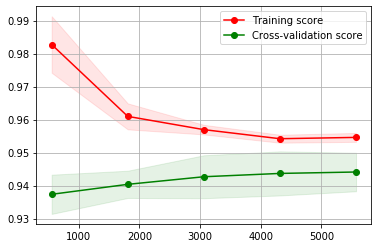

36433.92044668034


In [159]:
tr_rn, te_rn = orders_rn.iloc[10000:], orders_rn.iloc[:10000]

model = RandomForestClassifier(max_depth=5)

X_tr, y_tr = get_X_and_y(tr_rn)
X_te, y_te = get_X_and_y(te_rn)
ntp = get_n_total_price(orders_rn)


tr_model = test_model(model, X_tr, y_tr, mode='class_prob', n_total_price=ntp)



y_pred_prob = tr_model.predict_proba(X_te)
y_pred = y_pred_prob[:,1]*X_te[:,ntp].reshape(X_te.shape[0])

print(mse(y_te, y_pred))

RandomForestClassifier
Mean score:  25603.74944451481
Std:  20494.20327038793


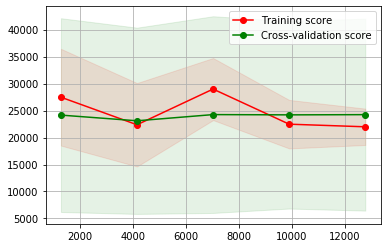

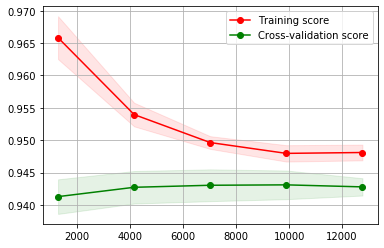

3487.9262693738833


In [158]:
tr_rn, te_rn = orders_rn.iloc[1000:], orders_rn.iloc[:1000]

model = RandomForestClassifier(max_depth=5)

X_tr, y_tr = get_X_and_y(tr_rn)
X_te, y_te = get_X_and_y(te_rn)
ntp = get_n_total_price(orders_rn)


tr_model = test_model(model, X_tr, y_tr, mode='class_prob', n_total_price=ntp)



y_pred_prob = tr_model.predict_proba(X_te)
y_pred = y_pred_prob[:,1]*X_te[:,ntp].reshape(X_te.shape[0])

print(mse(y_te, y_pred))

## Tu policzony udział w mse zamówień o wartości powyżej 1000 i pozostałych

In [19]:
tr_rn, te_rn = orders_rn.iloc[10000:], orders_rn.iloc[:10000]

model = RandomForestClassifier(max_depth=5)

X_tr, y_tr = get_X_and_y(tr_rn)

ntp = get_n_total_price(orders_rn)


tr_model = test_model(model, X_tr, y_tr, mode='class_prob', n_total_price=ntp, plot=False)


te1 = te_rn[te_rn['price_total'] >= 1000]
print(len(te1))
te2 = te_rn[te_rn['price_total'] < 1000]
print(len(te2))
X_te1, y_te1 = get_X_and_y(te1)
X_te2, y_te2 = get_X_and_y(te2)

y_pred_prob = tr_model.predict_proba(X_te1)
y_pred = y_pred_prob[:,1]*X_te1[:,ntp].reshape(X_te1.shape[0])
print('Orders with price total >= 1000: ', mse(y_te1, y_pred)*len(X_te1)/len(te_rn))

y_pred_prob = tr_model.predict_proba(X_te2)
y_pred = y_pred_prob[:,1]*X_te2[:,ntp].reshape(X_te2.shape[0])
print('Orders with price total < 1000: ', mse(y_te2, y_pred)*len(X_te2)/len(te_rn))

RandomForestClassifier
Mean score:  9592.931667583118
Std:  5730.089229980424
483
9517
Orders with price total >= 1000:  34932.70697912945
Orders with price total < 1000:  1325.4384671607768


In [168]:
tr_rn, te_rn = orders_rn.iloc[:10000], orders_rn.iloc[10000:]

model = RandomForestClassifier(max_depth=5)

X_tr, y_tr = get_X_and_y(tr_rn)

ntp = get_n_total_price(orders_rn)


tr_model = test_model(model, X_tr, y_tr, mode='class_prob', n_total_price=ntp, plot=False)


te1 = te_rn[te_rn['price_total'] >= 1000]
print(len(te1))
te2 = te_rn[te_rn['price_total'] < 1000]
print(len(te2))
X_te1, y_te1 = get_X_and_y(te1)
X_te2, y_te2 = get_X_and_y(te2)

y_pred_prob = tr_model.predict_proba(X_te1)
y_pred = y_pred_prob[:,1]*X_te1[:,ntp].reshape(X_te1.shape[0])
print('Group 1: ', mse(y_te1, y_pred)*len(X_te1)/len(te_rn))

y_pred_prob = tr_model.predict_proba(X_te2)
y_pred = y_pred_prob[:,1]*X_te2[:,ntp].reshape(X_te2.shape[0])
print('Group 2: ', mse(y_te2, y_pred)*len(X_te2)/len(te_rn))

RandomForestClassifier
Mean score:  29438.534335509416
Std:  26391.153248243598
333
6629
Group 1:  9809.278640500866
Group 2:  1248.345755546041


In [174]:
tr_rn, te_rn = orders_rn.iloc[10000:], orders_rn.iloc[:10000]

tr_rn = tr_rn[tr_rn['price_total'] < 1000]

model = RandomForestClassifier(max_depth=5)

X_tr, y_tr = get_X_and_y(tr_rn)

ntp = get_n_total_price(orders_rn)


tr_model = test_model(model, X_tr, y_tr, mode='class_prob', n_total_price=ntp, plot=False)


te1 = te_rn[te_rn['price_total'] >= 1000]
print(len(te1))
te2 = te_rn[te_rn['price_total'] < 1000]
print(len(te2))
X_te1, y_te1 = get_X_and_y(te1)
X_te2, y_te2 = get_X_and_y(te2)

y_pred_prob = tr_model.predict_proba(X_te1)
y_pred = y_pred_prob[:,1]*X_te1[:,ntp].reshape(X_te1.shape[0])
print('Group 1: ', mse(y_te1, y_pred)*len(X_te1)/len(te_rn))

y_pred_prob = tr_model.predict_proba(X_te2)
y_pred = y_pred_prob[:,1]*X_te2[:,ntp].reshape(X_te2.shape[0])
print('Group 2: ', mse(y_te2, y_pred)*len(X_te2)/len(te_rn))

RandomForestClassifier
Mean score:  1338.6979518134383
Std:  233.50077838446992
483
9517
Group 1:  33569.774146716176
Group 2:  1308.3069396330372


## Żeby stworzyć zgłoszenie potrzebujemy połączyć przewidywania dla zamówień klientów stałych i pozostałych

In [22]:
test = pd.read_hdf('data/test_online_retail.h5').reset_index(drop=True)

In [23]:
test_csv = pd.read_csv('data/orders_test.csv')
test_csv = test_csv.set_index('invoice', drop=False)

In [24]:
test = test[test['invoice'].isin(test_csv.index)]

In [25]:
test['stock_code_rat'] = test['stock_code'].map(stock_code_rat)
test['stock_code_canc'] = test['stock_code'].map(stock_code_canc)

In [26]:
orders_te = test.groupby('invoice').agg(item_num=('price_total', 'count'),
                                       price_total=('price_total', sum), m_expensive_item_total=('price_total', max),
                                      item_median_total=('price_total', np.median), l_expensive_item_total=('price_total', min),
                                      sum_quant=('quantity', sum), great_quant=('quantity', max), least_quent=('quantity', min),
                                     date=('invoice_date', 'first'), country=('country', 'first'),
                                     customer_id=('customer_id', 'first'),
                                     mean_scrat=('stock_code_rat', np.mean), min_scrat=('stock_code_rat', min),
                                     max_scrat=('stock_code_rat', max),
                                     mean_sccanc=('stock_code_canc', np.mean), min_sccanc=('stock_code_canc', min),
                                     max_sccanc=('stock_code_canc', max))

orders_te["date"] = orders_te['date'].astype("datetime64")
orders_te['year'] = orders_te['date'].dt.year
orders_te['month'] = orders_te['date'].dt.month
orders_te['weekday'] = orders_te['date'].dt.weekday
orders_te['hour'] = orders_te['date'].dt.hour


orders_te['country_val'] = pd.factorize(orders_te['country'])[0]

In [16]:
orders_te_rr = orders_te[orders_te['customer_id'].isin(regulars)]
orders_te_rn = orders_te[~orders_te['customer_id'].isin(regulars)]

In [20]:
model = RandomForestClassifier(max_depth=5)

X, y = get_X_and_y(orders_rn)
ntp = get_n_total_price(orders_rn)

model_rn = test_model(model, X, y, mode='class_prob', n_total_price=ntp, plot=False)

RandomForestClassifier
Mean score:  23778.81943729107
Std:  16478.400965735917


In [21]:
model = RandomForestClassifier(max_depth=5)

X, y = get_X_and_y(orders_rr)
ntp = get_n_total_price(orders_rr)

model_rr = test_model(model, X, y, mode='class_prob', n_total_price=ntp, plot=False)

RandomForestClassifier
Mean score:  54357.034206166994
Std:  30181.04337419316


In [19]:
def get_X(df):

    feats = df.select_dtypes(include=[np.int32, np.int64, np.float32, np.float64]).columns

    X_feats = feats[ (feats != 'num_canceled') & (feats != 'is_canceled') & (feats != 'total_return')].values
    X = df[X_feats].values
    
    return X

X_rn = get_X(orders_te_rn)
ntp = get_n_total_price(orders_te_rn)

y_pred_prob_rn = model_rn.predict_proba(X_rn)
y_pred_rn = y_pred_prob_rn[:,1]*X_rn[:,ntp].reshape(X_rn.shape[0])


test_csv.loc[list(orders_te_rn.index),'return_price'] = y_pred_rn

In [20]:
orders_te_rr['cust_inv'] = orders_te_rr['customer_id'].map(lambda x: customers.loc[x]['invoices'])
orders_te_rr['cust_canc'] = orders_te_rr['customer_id'].map(lambda x: customers.loc[x]['returns'])
orders_te_rr['cust_rat'] = orders_te_rr['cust_canc']/orders_te_rr['cust_inv']

/home/jan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [21]:
def get_X(df):

    feats = df.select_dtypes(include=[np.int32, np.int64, np.float32, np.float64]).columns

    X_feats = feats[ (feats != 'num_canceled') & (feats != 'is_canceled') & (feats != 'total_return')].values
    X = df[X_feats].values
    
    return X

X_rr = get_X(orders_te_rr)
ntp = get_n_total_price(orders_te_rr)

y_pred_prob_rr = model_rr.predict_proba(X_rr)
y_pred_rr = y_pred_prob_rr[:,1]*X_rr[:,ntp].reshape(X_rr.shape[0])


test_csv.loc[list(orders_te_rr.index),'return_price'] = y_pred_rr

In [34]:
test_csv = test_csv.rename(columns={'return_price': 'total_return'})

In [267]:
test_csv

,invoice,return_price
invoice,,
0,0,30.811953
1,1,6.106739
6,6,20.583180
7,7,2.871118
11,11,1.083215
...,...,...
53617,53617,1.121659
53618,53618,3.230316
53619,53619,3.902824


In [35]:
test_csv.to_csv('data/submit_mixed_model.csv', index=False)

## Możemy jeszcze podejrzeć feature importance naszych modeli

Feature ranking:
1. feature sum_quant (0.235658)
2. feature price_total (0.177331)
3. feature min_scrat (0.159037)
4. feature great_quant (0.113325)
5. feature item_num (0.090478)
6. feature min_sccanc (0.065902)
7. feature m_expensive_item_total (0.043571)
8. feature mean_scrat (0.041498)
9. feature item_median_total (0.016116)
10. feature mean_sccanc (0.015284)
11. feature max_scrat (0.013722)
12. feature l_expensive_item_total (0.012444)
13. feature max_sccanc (0.006202)
14. feature least_quent (0.005869)
15. feature hour (0.001442)
16. feature country_val (0.000876)
17. feature weekday (0.000624)
18. feature month (0.000544)
19. feature year (0.000075)


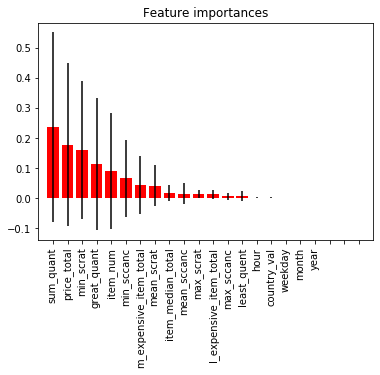

In [53]:
feats = orders_rn.select_dtypes(include=[np.int32, np.int64, np.float32, np.float64]).columns.to_list()

feature_names = [f for f in feats if f not in ['num_canceled', 'is_canceled', 'total_return']]

importances = model_rn.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rn.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(importances)):
    print("%d. feature %s (%f)" % (f+1, feature_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[x] for x in indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

Feature ranking:
1. feature min_scrat (0.140856)
2. feature mean_scrat (0.107088)
3. feature min_sccanc (0.103080)
4. feature sum_quant (0.084882)
5. feature cust_rat (0.075665)
6. feature l_expensive_item_total (0.066036)
7. feature item_median_total (0.058748)
8. feature great_quant (0.057873)
9. feature price_total (0.056203)
10. feature cust_inv (0.052498)
11. feature mean_sccanc (0.041972)
12. feature m_expensive_item_total (0.037983)
13. feature cust_canc (0.037116)
14. feature max_scrat (0.033849)
15. feature least_quent (0.022954)
16. feature item_num (0.009994)
17. feature max_sccanc (0.008662)
18. feature hour (0.001883)
19. feature country_val (0.001080)
20. feature month (0.000740)
21. feature weekday (0.000704)
22. feature year (0.000131)


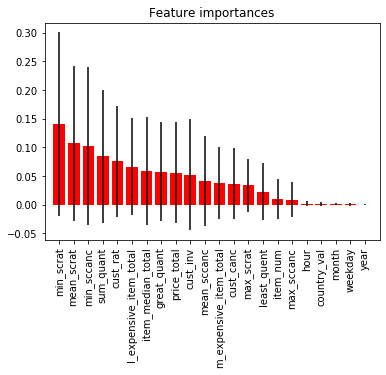

In [55]:
feats = orders_rr.select_dtypes(include=[np.int32, np.int64, np.float32, np.float64]).columns.to_list()

feature_names = [f for f in feats if f not in ['num_canceled', 'is_canceled', 'total_return']]

importances = model_rr.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(importances)):
    print("%d. feature %s (%f)" % (f+1, feature_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[x] for x in indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()